# Make predictions lightgbm model 2022

In [1]:
import os
print(os.cpu_count())

10


In [2]:
import os, sys

In [3]:
try:
  import random, os, sys, re, threading, queue, logging, optuna, darts, pickle

  from datetime import datetime, timedelta
  import numpy as np
  import pandas as pd

  from darts import TimeSeries
  from darts.models import LightGBMModel

  from optuna.visualization import plot_contour, plot_param_importances
  plotly_config = {"staticPlot": True}

  import seaborn as sns
  import matplotlib.pyplot as plt

except:
  !pip install -U packaging
  !pip install darts optuna lightgbm pandas numpy matplotlib

  import random, os, sys, re, threading, queue, logging, optuna, darts, pickle

  from datetime import datetime, timedelta
  import numpy as np
  import pandas as pd

  from darts import TimeSeries
  from darts.models import LightGBMModel

  from optuna.visualization import plot_contour, plot_param_importances
  plotly_config = {"staticPlot": True}

  import seaborn as sns
  import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [4]:
orig_df = pd.read_csv('../imputed_and_stitched_hosp.csv')

orig_df['date'] = pd.to_datetime(orig_df['date'])
orig_df = orig_df.drop(['ili', 'pred_hosp', 'true_hosp', 'population'], axis = 1)

pivoted_df = orig_df.pivot_table(index = 'date', columns = 'location_name', values = 'total_hosp').reset_index().rename(columns = {'index': 'date'})
pivoted_df = pivoted_df.drop(['Florida', 'Puerto Rico'], axis = 1).dropna()

df = pivoted_df[['date', 'US']].dropna()
df.columns = ['date', 'value']
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df = df.sort_index().reset_index()
df

,date,value
0,2012-10-06,996.0
1,2012-10-13,1527.0
2,2012-10-20,1494.0
3,2012-10-27,1626.0
4,2012-11-03,2257.0
...,...,...
599,2024-03-30,5445.0
600,2024-04-06,4951.0
601,2024-04-13,3954.0
602,2024-04-20,2859.0


In [5]:
def return_training_data(start_date, location):
    # import original data
    t_df = pd.read_csv('../imputed_and_stitched_hosp.csv')

    # drop irrelevant columns
    t_df['date'] = pd.to_datetime(t_df['date'])
    t_df = t_df.drop(['ili', 'pred_hosp', 'true_hosp', 'population'], axis = 1)

    # pivot the table
    t_pivoted_df = t_df.pivot_table(index = 'date', columns = 'location_name', values = 'total_hosp').reset_index().rename(columns = {'index': 'date'})
    t_pivoted_df.columns.name = None
    t_pivoted_df = t_pivoted_df.drop(['Florida', 'Puerto Rico'], axis = 1).dropna()

    # Convert the DataFrame into a Darts TimeSeries
    t_series = TimeSeries.from_dataframe(t_pivoted_df, 'date', t_pivoted_df.columns[1:])

    # Split the data into train and validation sets
    t_train, t_val = t_series.split_before(start_date)

    # Extract week number of the year and create an exogenous TimeSeries
    t_week_numbers = t_series.pd_dataframe().index.isocalendar().week

    t_week_series = TimeSeries.from_times_and_values(t_series.time_index, t_week_numbers)
    t_week_series = t_week_series.pd_dataframe().reset_index()
    t_week_series.columns = ['date', 'value']
    t_week_series = TimeSeries.from_dataframe(t_week_series, 'date', 'value')

    # Determine the last date and value in the original TimeSeries
    t_last_date = t_week_series.time_index[-1]
    t_last_value = t_week_series.values()[-1]

    # Generate new dates and values
    t_new_dates = pd.date_range(t_last_date + pd.Timedelta(weeks=1), t_last_date + pd.Timedelta(weeks=10), freq = 'W-SAT')
    t_new_values = [t_last_value + i for i in range(1, len(t_new_dates) + 1)]

    # Create a new TimeSeries object
    t_new_week_series = TimeSeries.from_dataframe(pd.DataFrame({'date': t_new_dates, 'value': t_new_values}), 'date', 'value')

    # Convert to DataFrames
    t_df1 = t_week_series.pd_dataframe().reset_index()
    t_df2 = t_new_week_series.pd_dataframe().reset_index()

    # Concatenate DataFrames
    tc_df = pd.concat([t_df1, t_df2], ignore_index=True)

    # Create a new weekly object
    t_week_series = TimeSeries.from_dataframe(tc_df, 'date', 'value')

    # Convert to dataframe for manipulation
    t_train = t_train.pd_dataframe()
    t_val = t_val.pd_dataframe()
    t_week_series = t_week_series.pd_dataframe()

    t_train.columns.name = None
    t_val.columns.name = None

    # Split into relevant columns
    t_exog = t_train.drop([location], axis = 1)
    t_train = t_train[[location]]
    t_val = t_val[[location]]

    # Convert back to TimeSeries
    t_train = TimeSeries.from_dataframe(t_train)
    t_exog = TimeSeries.from_dataframe(t_exog)
    t_val = TimeSeries.from_dataframe(t_val)
    t_weeks = TimeSeries.from_dataframe(t_week_series)

    return t_train, t_exog, t_val, t_weeks

def return_forecast_data(location):
    # import original data
    t_df = pd.read_csv('../imputed_and_stitched_hosp.csv')

    # drop irrelevant columns
    t_df['date'] = pd.to_datetime(t_df['date'])
    t_df = t_df.drop(['ili', 'pred_hosp', 'true_hosp', 'population'], axis = 1)

    # pivot the table
    t_pivoted_df = t_df.pivot_table(index = 'date', columns = 'location_name', values = 'total_hosp').reset_index().rename(columns = {'index': 'date'})
    t_pivoted_df.columns.name = None
    t_pivoted_df = t_pivoted_df.drop(['Florida', 'Puerto Rico'], axis = 1).dropna()

    # Convert the DataFrame into a Darts TimeSeries
    t_series = TimeSeries.from_dataframe(t_pivoted_df, 'date', t_pivoted_df.columns[1:])

    # Extract week number of the year and create an exogenous TimeSeries
    t_week_numbers = t_series.pd_dataframe().index.isocalendar().week

    t_week_series = TimeSeries.from_times_and_values(t_series.time_index, t_week_numbers)
    t_week_series = t_week_series.pd_dataframe().reset_index()
    t_week_series.columns = ['date', 'value']
    t_week_series = TimeSeries.from_dataframe(t_week_series, 'date', 'value')

    # Determine the last date and value in the original TimeSeries
    t_last_date = t_week_series.time_index[-1]
    t_last_value = t_week_series.values()[-1]

    # Generate new dates and values
    t_new_dates = pd.date_range(t_last_date + pd.Timedelta(weeks=1), t_last_date + pd.Timedelta(weeks=10), freq = 'W-SAT')
    t_new_values = [t_last_value + i for i in range(1, len(t_new_dates) + 1)]

    # Create a new TimeSeries object
    t_new_week_series = TimeSeries.from_dataframe(pd.DataFrame({'date': t_new_dates, 'value': t_new_values}), 'date', 'value')

    # Convert to DataFrames
    t_df1 = t_week_series.pd_dataframe().reset_index()
    t_df2 = t_new_week_series.pd_dataframe().reset_index()

    # Concatenate DataFrames
    tc_df = pd.concat([t_df1, t_df2], ignore_index=True)

    # Create a new weekly object
    t_week_series = TimeSeries.from_dataframe(tc_df, 'date', 'value')

    # Convert to dataframe for manipulation
    t_series = t_series.pd_dataframe()
    t_week_series = t_week_series.pd_dataframe()

    t_series.columns.name = None

    # Split into relevant columns
    t_exog = t_series.drop([location], axis = 1)
    t_series = t_series[[location]]

    # Convert back to TimeSeries
    t_series = TimeSeries.from_dataframe(t_series)
    t_exog = TimeSeries.from_dataframe(t_exog)
    t_weeks = TimeSeries.from_dataframe(t_week_series)

    return t_series, t_exog, t_weeks

In [6]:
def rmse(forecast, actual):
    return np.sqrt(np.mean((forecast - actual)**2))

In [7]:
# Specify the SQLite database for storage
study_path = "models/locations_studies_full_horizon_2022_h5_c100_1.db"

# Get all study summaries from the SQLite storage
study_summaries = optuna.study.get_all_study_summaries(storage=f"sqlite:///{study_path}")

locations_studies = {}

# Load each study using its name
loaded_studies_dict = {}
for summary in study_summaries:
    study_name = summary.study_name
    loaded_study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_path}")
    locations_studies[study_name] = loaded_study

parameters_path = "models/locations_best_params_full_horizon_2022_h5_c100_1.pkl"

with open(parameters_path, 'rb') as f:
    locations_best_params = pickle.load(f)

In [8]:
example_location = 'US'

fig = plot_contour(locations_studies[example_location])
fig.update_layout(width=1200, height=1000)
fig.show(config=plotly_config)

[W 2024-05-01 11:56:23,174] Param learning_rate unique value length is less than 2.
[W 2024-05-01 11:56:23,175] Param metric unique value length is less than 2.
[W 2024-05-01 11:56:23,176] Param n_jobs unique value length is less than 2.
[W 2024-05-01 11:56:23,177] Param learning_rate unique value length is less than 2.
[W 2024-05-01 11:56:23,178] Param learning_rate unique value length is less than 2.
[W 2024-05-01 11:56:23,178] Param metric unique value length is less than 2.
[W 2024-05-01 11:56:23,179] Param learning_rate unique value length is less than 2.
[W 2024-05-01 11:56:23,180] Param learning_rate unique value length is less than 2.
[W 2024-05-01 11:56:23,180] Param n_jobs unique value length is less than 2.
[W 2024-05-01 11:56:23,181] Param learning_rate unique value length is less than 2.
[W 2024-05-01 11:56:23,182] Param learning_rate unique value length is less than 2.
[W 2024-05-01 11:56:23,183] Param metric unique value length is less than 2.
[W 2024-05-01 11:56:23,185]

In [9]:
fig = plot_param_importances(locations_studies[example_location])
fig.update_layout(width=1200,height=1000)
fig.show(config=plotly_config)

In [10]:
#best_params = {'learning_rate':0.125, 'num_leaves': 30, 'max_depth': 3, 'min_child_samples': 8, 'lambda_l2': 0.26, 'lags': 2} ## US

horizon = 5
start = pd.Timestamp('2024-01-01')

all_horizons_reals = {}
all_horizons_predictions = {}
all_horizons_persistence = {}

for h in range(1, horizon+1):
    all_location_reals = {}
    all_location_predictions = {}
    all_location_persistence = {}

    for a_location in locations_best_params.keys():
        print(f'\nComputing forecasts for {a_location}\n')

        df = pivoted_df[['date', a_location]].dropna()
        df.columns = ['date', 'value']
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')

        df = df.sort_index().reset_index()

        train_series, exog_series, val_series, week_series = return_training_data(start, a_location)

        # Rolling prediction using best parameters
        predictions = []

        for i in range(len(val_series)):
            if i%5 == 0:
                print(f'Predicting value: {i}')
            new_date = start + timedelta(weeks=i)

            # Split the data into train and validation sets
            train_tmp, exog_tmp, val_tmp, week_tmp = return_training_data(new_date, a_location)

            model = LightGBMModel(lags_past_covariates=list(range(-locations_best_params[a_location]['lags'],-(h-1))),
                                  lags_future_covariates=[0],
                                  verbosity=-1, **locations_best_params[a_location])
            model.fit(train_tmp, past_covariates = exog_tmp, future_covariates = week_tmp)

            pred = model.predict(h, past_covariates = exog_tmp, future_covariates = week_tmp)
            predictions.append(pred.univariate_values()[-1])

        train_series, exog_series, week_series = return_forecast_data(a_location)
        model = LightGBMModel(lags_past_covariates=list(range(-locations_best_params[a_location]['lags'],-(h-1))),
                              lags_future_covariates=[0],
                              verbosity=-1,
                              **locations_best_params[a_location])
        
        model.fit(train_series, past_covariates = exog_series, future_covariates = week_series)
        pred = model.predict(h, past_covariates = exog_series, future_covariates = week_series)
        predictions.append(pred.univariate_values()[-1])

        all_location_reals[a_location] = val_series.pd_dataframe()[[a_location]].values.flatten()
        all_location_predictions[a_location] = predictions
        all_location_persistence[a_location] = df.iloc[-(len(val_series)+h):-h]['value'].values

    all_horizons_reals[h] = all_location_reals
    all_horizons_predictions[h] = all_location_predictions
    all_horizons_persistence[h] = all_location_persistence


Computing forecasts for Alabama

Predicting value: 0
Predicting value: 5
Predicting value: 10
Predicting value: 15

Computing forecasts for Alaska

Predicting value: 0
Predicting value: 5
Predicting value: 10
Predicting value: 15

Computing forecasts for Arizona

Predicting value: 0
Predicting value: 5
Predicting value: 10
Predicting value: 15

Computing forecasts for Arkansas

Predicting value: 0
Predicting value: 5
Predicting value: 10
Predicting value: 15

Computing forecasts for California

Predicting value: 0
Predicting value: 5
Predicting value: 10
Predicting value: 15

Computing forecasts for Colorado

Predicting value: 0
Predicting value: 5
Predicting value: 10
Predicting value: 15

Computing forecasts for Connecticut

Predicting value: 0
Predicting value: 5
Predicting value: 10
Predicting value: 15

Computing forecasts for Delaware

Predicting value: 0
Predicting value: 5
Predicting value: 10
Predicting value: 15

Computing forecasts for District of Columbia

Predicting value

In [11]:
df_reals = pd.DataFrame(all_horizons_reals)
df_predictions = pd.DataFrame(all_horizons_predictions)
df_persistence = pd.DataFrame(all_horizons_persistence)

new_df_reals = pd.DataFrame()
new_df_predictions = pd.DataFrame()
new_df_persistence = pd.DataFrame()

for col in df_reals.columns:
  sre = df_reals[col].apply(pd.Series).transpose()
  spr = df_predictions[col].apply(pd.Series).transpose().round().astype(int)
  spe = df_persistence[col].apply(pd.Series).transpose()

  sre['horizon'] = np.repeat(col, len(sre))
  spr['horizon'] = np.repeat(col, len(spr))
  spe['horizon'] = np.repeat(col, len(spe))

  sre['type'] = np.repeat('real', len(sre))
  spr['type'] = np.repeat('prediction', len(spr))
  spe['type'] = np.repeat('persistence', len(spe))

  sre['date'] = val_series.pd_dataframe().reset_index().date
  spr['date'] = val_series.pd_dataframe().reset_index().date
  spe['date'] = val_series.pd_dataframe().reset_index().date
  spr['date'] = spr['date'].fillna(np.max(spr.date) + pd.to_timedelta(spr['horizon'], unit='w'))

  new_df_reals = pd.concat([new_df_reals, sre], axis=0)
  new_df_predictions = pd.concat([new_df_predictions, spr], axis=0)
  new_df_persistence = pd.concat([new_df_persistence, spe], axis=0)

new_df = pd.concat([new_df_reals, new_df_predictions, new_df_persistence], axis=0)

In [12]:
# pivot the data frames longer
new_df = new_df.melt(id_vars=['date', 'type', 'horizon'], var_name='location', value_name='value')

display(new_df)

,date,type,horizon,location,value
0,2024-01-06,real,1,Alabama,350.0
1,2024-01-13,real,1,Alabama,237.0
2,2024-01-20,real,1,Alabama,173.0
3,2024-01-27,real,1,Alabama,143.0
4,2024-02-03,real,1,Alabama,103.0
...,...,...,...,...,...
13255,2024-03-30,persistence,5,Wyoming,27.0
13256,2024-04-06,persistence,5,Wyoming,25.0
13257,2024-04-13,persistence,5,Wyoming,15.0
13258,2024-04-20,persistence,5,Wyoming,11.0


In [13]:
last_real = np.max(val_series.pd_dataframe().reset_index().date)

predictions_rmse = new_df.loc[new_df.date <= last_real].groupby('horizon').apply(lambda x: rmse(x.loc[x['type']=='real']['value'].values, x.loc[x['type']=='prediction']['value'].values))
persistence_rmse = new_df.loc[new_df.date <= last_real].groupby('horizon').apply(lambda x: rmse(x.loc[x['type']=='real']['value'].values, x.loc[x['type']=='persistence']['value'].values))

df_rmse = pd.concat([predictions_rmse, persistence_rmse], axis=1)
df_rmse.columns = ['predictions', 'persistence']

display(df_rmse)

,predictions,persistence
horizon,,
1,246.274762,210.670953
2,317.005270,405.173893
3,396.573984,588.585384
4,511.997959,732.052185
5,597.177657,853.560467


In [14]:
predictions_rmse = new_df.loc[new_df.date <= last_real].groupby(['location', 'horizon']).apply(lambda x: rmse(x.loc[x['type']=='real']['value'].values, x.loc[x['type']=='prediction']['value'].values))
persistence_rmse = new_df.loc[new_df.date <= last_real].groupby(['location', 'horizon']).apply(lambda x: rmse(x.loc[x['type']=='real']['value'].values, x.loc[x['type']=='persistence']['value'].values))

df_rmse = pd.concat([predictions_rmse, persistence_rmse], axis=1)
df_rmse.columns = ['predictions', 'persistence']

display(df_rmse)

predictions  persistence
location horizon                          
Alabama  1          37.059570    38.190698
         2          49.536083    59.758829
         3          52.575995    87.968243
         4          61.620279   107.242715
         5          71.566916   119.056339
...                       ...          ...
Wyoming  1          13.253191    13.173056
         2          14.720933    22.459113
         3          14.800636    22.643010
         4          17.751553    21.797194
         5          19.949937    26.541865

[255 rows x 2 columns]

In [15]:
df_rmse.groupby(['horizon']).apply(lambda x: np.sum(x['predictions'] <= x['persistence']))

horizon
1    10
2    32
3    38
4    43
5    46
dtype: int64

In [16]:
df_predictions = new_df.loc[(new_df.horizon == 1) | (new_df.date > last_real)].drop(['horizon'], axis = 1)
df_predictions = df_predictions.pivot(index = ['date', 'location'], columns = 'type', values = 'value').reset_index()
df_predictions

type,date,location,persistence,prediction,real
0,2024-01-06,Alabama,298.0,221.0,350.0
1,2024-01-06,Alaska,4.0,8.0,5.0
2,2024-01-06,Arizona,1151.0,844.0,935.0
3,2024-01-06,Arkansas,187.0,232.0,234.0
4,2024-01-06,California,1752.0,1225.0,1420.0
...,...,...,...,...,...
1117,2024-06-01,Virginia,NaN,22.0,NaN
1118,2024-06-01,Washington,NaN,20.0,NaN
1119,2024-06-01,West Virginia,NaN,10.0,NaN
1120,2024-06-01,Wisconsin,NaN,-1.0,NaN


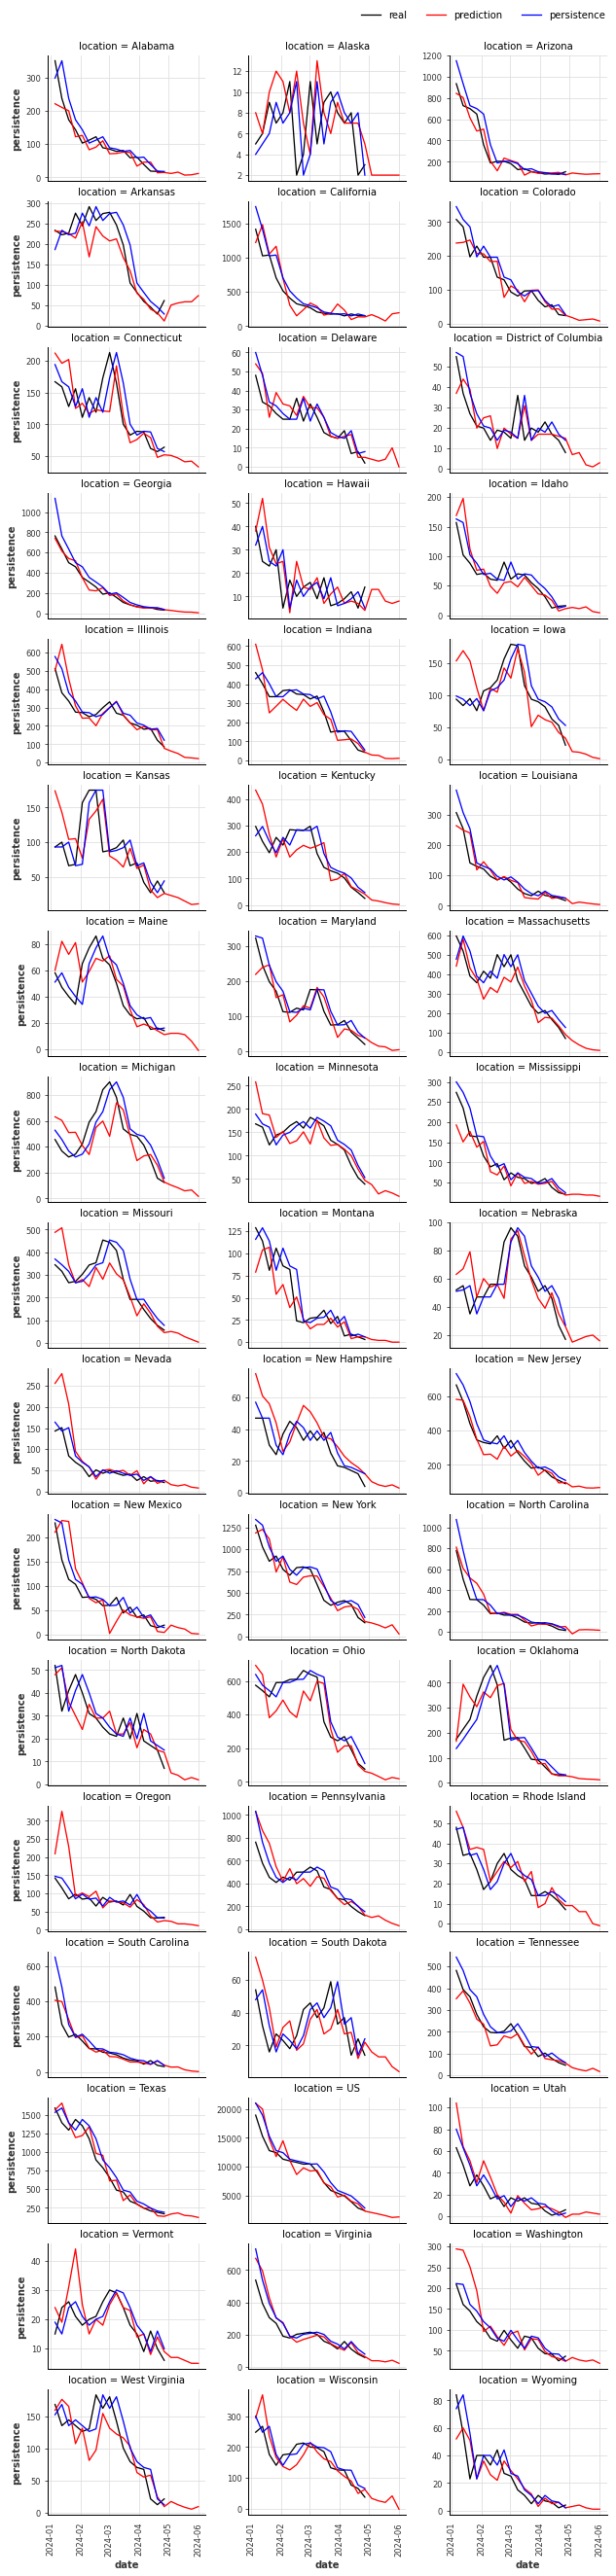

In [17]:
# Plotting
g = sns.FacetGrid(df_predictions, col="location", col_wrap=3, height=3, sharey=False)
g = g.map_dataframe(sns.lineplot, 'date', 'real', color = 'black', label = 'real')
g = g.map_dataframe(sns.lineplot, 'date', 'prediction', color = 'red', label = 'prediction')
g = g.map_dataframe(sns.lineplot, 'date', 'persistence', color = 'blue', label = 'persistence')

# Remove individual legends
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.legend().set_visible(False)

# Add a centralized legend to the top
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g.fig.subplots_adjust(top=0.7)  # Make some space at the top of the figure
g.fig.legend(handles=handles, labels=labels, loc='upper right', bbox_to_anchor=(0.98, 0.715), ncol=3)

plt.show()

In [18]:
g.savefig("lightgbm_predictions_c100_mod2022.pdf")

In [19]:
pd.DataFrame(locations_best_params).transpose()

,metric,n_estimators,num_leaves,max_depth,learning_rate,min_child_samples,n_jobs,lags
Alabama,rmse,1000,30,4,0.1,12,-1,10
Alaska,rmse,300,27,5,0.1,2,-1,13
Arizona,rmse,900,22,2,0.1,15,-1,10
Arkansas,rmse,900,30,2,0.1,10,-1,11
California,rmse,1000,16,2,0.1,16,-1,6
Colorado,rmse,1000,8,2,0.1,16,-1,8
Connecticut,rmse,600,25,2,0.1,3,-1,11
Delaware,rmse,1000,31,2,0.1,16,-1,6
District of Columbia,rmse,1000,9,2,0.1,16,-1,5
Georgia,rmse,100,19,2,0.1,11,-1,13


In [20]:
new_df = new_df.loc[(new_df.type == 'real') | (new_df.type == 'prediction')]
new_df = new_df.pivot_table(index = ['date', 'horizon', 'location'], columns = 'type', values = 'value', fill_value=np.nan).reset_index()

new_df['date_predicted'] = new_df['date']
new_df['location_name'] = new_df['location']
new_df['value'] = new_df['prediction']
new_df['target_value'] = new_df['real']

new_df['aggregation'] = 'weekly'
new_df['model'] = 'lightgbm'
new_df['target'] = 'value'
new_df['date_created'] = pd.Timestamp.today().strftime('%Y-%m-%d')

new_df = new_df.drop(['date', 'location', 'prediction', 'real'], axis = 1)

new_order = ['date_created', 'date_predicted', 'aggregation', 'location_name', 'model', 'target', 'horizon', 'value', 'target_value']
new_df = new_df.reindex(columns=new_order)

new_df = new_df.sort_values(by=['location_name', 'date_predicted'])

new_df.to_csv('lightgbm_predictions_mod2022_h5_c100_1_2024-04-27.csv', index=False, na_rep='NA')